# Classifying Events by Type

A similar application is the Facebook Event Classifier, which attempts to categorize events (e.g. parties, concerts, games).

Using Google's document on "Best Practices in Machine Learning" as a guide. 

http://martin.zinkevich.org/rules_of_ml/rules_of_ml.pdf

### Import Packages and Data

In [353]:
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;

import string, nltk, re, pprint

from functools import reduce
from tqdm import tqdm
from pylab import *;
from scipy import sparse
from time import time

from nltk.corpus   import stopwords
from nltk          import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.corpus import stopwords

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error;
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

import lightgbm as lgb;

from wordcloud import WordCloud, STOPWORDS

eng_stopwords = set(stopwords.words("english"))

%matplotlib inline

In [367]:
events = pd.read_csv('raw_data/cleaned_up.csv')

# Totally Random Guessing

Totally random guessing gives an F1 score of 0.1

In [228]:
le = LabelEncoder()

le.fit(events['Type'].values)

labels = le.classes_

print(le.classes_)

y = le.transform(events['Type'].values) 

['Adult-oriented' 'Care/Support' 'Class/Workshop' 'Fire' 'Food' 'Game'
 'Gathering/Party' 'Kid-friendly' 'Other' 'Parade' 'Performance'
 'Ritual/Ceremony']


In [261]:
print("Classification Report")
print(classification_report(y, [random.randint(0, 11) for x in range(len(y))], target_names=labels));
print("\n")

Classification Report
                 precision    recall  f1-score   support

 Adult-oriented       0.06      0.08      0.07      1124
   Care/Support       0.04      0.08      0.05       744
 Class/Workshop       0.29      0.07      0.12      6419
           Fire       0.01      0.07      0.01       162
           Food       0.04      0.07      0.05       838
           Game       0.05      0.08      0.06       948
Gathering/Party       0.25      0.08      0.12      5282
   Kid-friendly       0.02      0.10      0.04       363
          Other       0.07      0.09      0.08      1421
         Parade       0.01      0.07      0.02       281
    Performance       0.07      0.08      0.08      1557
Ritual/Ceremony       0.05      0.08      0.06      1026

    avg / total       0.18      0.08      0.10     20165





Weighed by prior event distributions brings this up to around 0.19

In [340]:
pred = np.random.choice(12, len(y), p=[list(y).count(0)/len(y),
                                       list(y).count(1)/len(y),
                                       list(y).count(2)/len(y),
                                       list(y).count(3)/len(y),
                                       list(y).count(4)/len(y),
                                       list(y).count(5)/len(y),
                                       list(y).count(6)/len(y),
                                       list(y).count(7)/len(y),
                                       list(y).count(8)/len(y),
                                       list(y).count(9)/len(y),
                                       list(y).count(10)/len(y),
                                       list(y).count(11)/len(y)])

print("Classification Report")
print(classification_report(y, pred, target_names=labels));
print("\n")

Classification Report
                 precision    recall  f1-score   support

 Adult-oriented       0.06      0.06      0.06      1124
   Care/Support       0.03      0.03      0.03       744
 Class/Workshop       0.32      0.32      0.32      6419
           Fire       0.00      0.00      0.00       162
           Food       0.05      0.05      0.05       838
           Game       0.05      0.05      0.05       948
Gathering/Party       0.26      0.26      0.26      5282
   Kid-friendly       0.01      0.01      0.01       363
          Other       0.07      0.07      0.07      1421
         Parade       0.03      0.02      0.03       281
    Performance       0.07      0.07      0.07      1557
Ritual/Ceremony       0.05      0.05      0.05      1026

    avg / total       0.19      0.19      0.19     20165





# Simple Rule-Based Classification

Let's see what accuracy we can achieve using an extremely simple rule-based classification scheme, based on findings from the Exploratory Data Analysis.

This simple rule system brings the Precision up to 0.33, but drops the Recall and F1 scores down relative to weighted random guessing.

In [368]:
events["Description"] = (events["Description"].map(str) + ' ' + 
                         events["Title"].map(str) + ' ' + 
                         events["Hosted by Camp"].map(str) + ' ' + 
                         events["Location"].map(str))

events = events.drop(['Title', 'Hosted by Camp', 'Location'], axis=1)

In [162]:
def simple_classification(desc):

    adult_words  = ['adult', 'massage', 'sensual', 'erotic', 'sex', 'bdsm', 'pleasure']
    care_words   = ['heal', 'massage', 'help', 'body']
    class_words  = ['learn', 'workshop', 'practice', 'class']
    fire_words   = ['fire', 'burn', 'spin', 'fuel', 'flame', 'light', 'flow']
    food_words   = ['coffee', 'pickle', 'food', 'serv', 'fresh', 'bacon', 'cheese', 'delicious', 'pancake', 'tast']
    game_words   = ['game', 'play', 'prize', 'race', 'tournament']
    party_words  = ['party', 'dance', 'music', 'celebrate']
    kids_words   = ['kid', 'scout']
    parade_words = ['parade', 'march', 'tour']
    perfor_words = ['perform', 'stage', 'live', 'show', 'audience']
    ritual_words = ['ceremony', 'ritual', 'temple', 'sacred']

    if any([word in desc for word in fire_words]):
        return 4
    elif any([word in desc for word in adult_words]):
        return 0
    elif any([word in desc for word in care_words]):
        return 1
    elif any([word in desc for word in class_words]):
        return 2
    elif any([word in desc for word in food_words]):
        return 5
    elif any([word in desc for word in game_words]):
        return 6
    elif any([word in desc for word in party_words]):
        return 7
    elif any([word in desc for word in kids_words]):
        return 8
    elif any([word in desc for word in parade_words]):
        return 10
    elif any([word in desc for word in ritual_words]):
        return 11
    else:
        return 9

In [163]:
pred = events['Description'].apply(simple_classification).values

In [164]:
cf = confusion_matrix(y, pred)

df_cf = pd.DataFrame(cf, columns=labels, index=labels)

df_cf

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,429,57,58,0,164,66,107,19,1,213,3,7
Care/Support,68,150,18,0,115,66,59,19,2,233,5,9
Class/Workshop,532,1036,1133,0,977,158,411,196,9,1773,42,152
Fire,0,0,0,0,141,1,4,2,0,14,0,0
Food,20,51,31,0,116,364,35,20,2,193,3,3
Game,39,44,40,0,136,56,349,12,4,265,1,2
Gathering/Party,191,239,207,0,1049,651,587,782,6,1526,22,22
Kid-friendly,9,34,18,0,91,25,55,9,12,107,2,1
Other,56,141,109,0,216,120,163,96,2,474,15,29
Parade,19,16,6,0,48,10,52,18,1,76,34,1


In [165]:
df_cf_norm = df_cf.copy()

for column in df_cf_norm.columns.values:
    df_cf_norm[column] = round(df_cf_norm[column]/df_cf_norm[column].values.sum(), 2)
    
df_cf_norm

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,0.30,0.03,0.03,NaN,0.05,0.04,0.05,0.01,0.02,0.04,0.02,0.02
Care/Support,0.05,0.08,0.01,NaN,0.03,0.04,0.03,0.01,0.05,0.04,0.03,0.03
Class/Workshop,0.37,0.53,0.65,NaN,0.28,0.10,0.19,0.14,0.22,0.31,0.28,0.47
Fire,0.00,0.00,0.00,NaN,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Food,0.01,0.03,0.02,NaN,0.03,0.22,0.02,0.01,0.05,0.03,0.02,0.01
Game,0.03,0.02,0.02,NaN,0.04,0.03,0.16,0.01,0.10,0.05,0.01,0.01
Gathering/Party,0.13,0.12,0.12,NaN,0.30,0.39,0.27,0.54,0.15,0.27,0.15,0.07
Kid-friendly,0.01,0.02,0.01,NaN,0.03,0.02,0.03,0.01,0.29,0.02,0.01,0.00
Other,0.04,0.07,0.06,NaN,0.06,0.07,0.08,0.07,0.05,0.08,0.10,0.09
Parade,0.01,0.01,0.00,NaN,0.01,0.01,0.02,0.01,0.02,0.01,0.23,0.00


In [166]:
print("Classification Report")
print(classification_report(y, pred, target_names=labels));
print("\n")

Classification Report


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

 Adult-oriented       0.30      0.38      0.34      1124
   Care/Support       0.08      0.20      0.11       744
 Class/Workshop       0.65      0.18      0.28      6419
           Fire       0.00      0.00      0.00       162
           Food       0.03      0.14      0.05       838
           Game       0.03      0.06      0.04       948
Gathering/Party       0.27      0.11      0.16      5282
   Kid-friendly       0.01      0.02      0.01       363
          Other       0.05      0.00      0.00      1421
         Parade       0.01      0.27      0.03       281
    Performance       0.15      0.01      0.03      1557
Ritual/Ceremony       0.24      0.08      0.11      1026

    avg / total       0.33      0.13      0.17     20165





# More Complex Feature Engineering

In [392]:
def convert_12_to_24(time):
    if 'a.m.' in time:
        time = time.replace(' a.m.', '')
        if ':' not in time:
            time = time + ':00'    
    elif 'p.m.' in time:
        time = time.replace(' p.m.', '')
        if ':' not in time:
            if '12' in time:
                time = time + ':00'
            else:
                time = str(int(time)+12) + ':00'
        elif '12' in time:
            pass
        else:
            time_split = time.split(':')
            time = str(int(time_split[0])+12) + ':' + time_split[1]
    elif 'midnight' in time:
        time = '23:45'
    elif 'noon' in time:
        time = '12:00'
            
    return time

def get_time_diff(df):      
    times = [];

    for row in tqdm(df.values): 
        if row == '0':
            times.append(np.nan);
        elif row == 'All Day':
            times.append((datetime.datetime.strptime('23:59', '%H:%M')-datetime.datetime.strptime('00:00', '%H:%M')).total_seconds()/3600)
        else:
            split = row.split(' – ');
            
            split[0] = convert_12_to_24(split[0])
            split[1] = convert_12_to_24(split[1])

            times.append((datetime.datetime.strptime(split[1], '%H:%M')-datetime.datetime.strptime(split[0], '%H:%M')).total_seconds()/3600)
    
    return times;

def get_start_times(df):      
    times = [];

    for row in tqdm(df.values): 
        if row == '0':
            times.append(np.nan);
        elif row == 'All Day':
            times.append(0)
        else:
            split = row.split(' – ');
            time = datetime.datetime.strptime(convert_12_to_24(split[0]), '%H:%M')
            times.append(60*time.hour + time.minute)
    
    return times;

In [388]:
times_1 = pd.DataFrame(get_time_diff(events['Sunday']),    columns=['Event Length'])
times_2 = pd.DataFrame(get_time_diff(events['Monday']),    columns=['Event Length'])
times_3 = pd.DataFrame(get_time_diff(events['Tuesday']),   columns=['Event Length'])
times_4 = pd.DataFrame(get_time_diff(events['Wednesday']), columns=['Event Length'])
times_5 = pd.DataFrame(get_time_diff(events['Thursday']),  columns=['Event Length'])
times_6 = pd.DataFrame(get_time_diff(events['Friday']),    columns=['Event Length'])
times_7 = pd.DataFrame(get_time_diff(events['Saturday']),  columns=['Event Length'])
times_8 = pd.DataFrame(get_time_diff(events['Sunday2']),   columns=['Event Length'])
times_9 = pd.DataFrame(get_time_diff(events['Monday2']),   columns=['Event Length'])

times = times_1.fillna(times_2).fillna(times_3).fillna(times_4).fillna(times_5).fillna(times_6).fillna(times_7).fillna(times_8).fillna(times_9)

events['Event Length'] = abs(times)

100%|███████████████████████████████████████████████████████████████████████| 20165/20165 [00:00<00:00, 1007398.31it/s]


In [393]:
start_times_1 = pd.DataFrame(get_start_times(events['Sunday']),    columns=['Start Time'])
start_times_2 = pd.DataFrame(get_start_times(events['Monday']),    columns=['Start Time'])
start_times_3 = pd.DataFrame(get_start_times(events['Tuesday']),   columns=['Start Time'])
start_times_4 = pd.DataFrame(get_start_times(events['Wednesday']), columns=['Start Time'])
start_times_5 = pd.DataFrame(get_start_times(events['Thursday']),  columns=['Start Time'])
start_times_6 = pd.DataFrame(get_start_times(events['Friday']),    columns=['Start Time'])
start_times_7 = pd.DataFrame(get_start_times(events['Saturday']),  columns=['Start Time'])
start_times_8 = pd.DataFrame(get_start_times(events['Sunday2']),   columns=['Start Time'])
start_times_9 = pd.DataFrame(get_start_times(events['Monday2']),   columns=['Start Time'])

start_times = start_times_1.fillna(start_times_2).fillna(start_times_3).fillna(start_times_4).fillna(start_times_5).fillna(start_times_6).fillna(start_times_7).fillna(start_times_8).fillna(start_times_9)

events['Start Time'] = start_times

100%|███████████████████████████████████████████████████████████████████████| 20165/20165 [00:00<00:00, 1341190.26it/s]


In [397]:
# Convert Days to Simple Binary (Lose Time of Day Information)

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2'];

events[days] = ((events[days] == '0') == False).astype(int);

In [398]:
events['Times Repeated'] = 0

for day in days:
    events['Times Repeated'] += events[day]

In [399]:
# Convert Contact Email, URL to Binary

events['Contact Email']  = pd.isnull(events['Contact Email']).values.astype(int)
events['URL']            = pd.isnull(events['URL']).values.astype(int)
events['Located at Art'] = pd.isnull(events['Located at Art']).values.astype(int)

In [82]:
# Convert Location to Binary

#events['Location']       = pd.isnull(events['Location']).values.astype(int)

In [83]:
# Convert Hosted by Camp to Binary

#events['Hosted by Camp']       = pd.isnull(events['Hosted by Camp']).values.astype(int)

In [401]:
events.sample(5)

,Description,Type,Contact Email,URL,Located at Art,Year,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Event Length,Start Time,Times Repeated
19270,Playa got you wound up? Come medidate and zen ...,Care/Support,1,1,1,2017,0,0,0,0,1,0,0,0,0,1.0,780.0,1
2460,Pittsburghers come by for the 4th annual Pitts...,Gathering/Party,0,1,1,2010,0,0,0,1,0,0,0,0,0,3.0,1200.0,1
19325,"Explore your creative impulse through voice, m...",Class/Workshop,1,1,1,2017,0,0,0,0,1,0,0,0,0,2.0,840.0,1
8340,"Join us for Ladies Night, Thursday from 6-9pm ...",Gathering/Party,1,0,1,2013,0,0,0,0,1,0,0,0,0,3.0,1080.0,1
7222,Study ancient Daoist energetic medicine. Shed ...,Class/Workshop,1,1,1,2013,0,0,1,0,0,0,0,0,0,2.0,630.0,1


Let's first build a classifier with simple engineered features (no TF-IDF) and see how it performs.

In [402]:
#######################
# FEATURE ENGINEERING #
#######################

def engineer_feature(series, func, normalize=True):
    feature = series.apply(func)
       
    if normalize:
        feature = pd.Series(z_normalize(feature.values.reshape(-1,1)).reshape(-1,))
    feature.name = func.__name__ 
    return feature

def engineer_features(series, funclist, normalize=True):
    features = pd.DataFrame()
    for func in funclist:
        print(str(func))
        feature = engineer_feature(series, func, normalize)
        features[feature.name] = feature
    return features

##################
### Normalizer ###
##################

scaler = StandardScaler()
def z_normalize(data):
    scaler.fit(data)
    return scaler.transform(data)
    
def count_words(x, words):
    count = 0
    for word in words:
        count += len(re.findall(word, str(x)))
    return count
    
################
### Features ###
################

def uppercase_freq(x):
    return len(re.findall(r'[A-Z]', x))/len(x)

def sentence_count(x):
    return len(re.findall("\n", str(x)))+1

def word_count(x):
    return len(str(x).split())

def unique_word_count(x):
    return len(set(str(x).split()))

def count_letters(x):
    return len(str(x))

def count_punctuations(x):
    return len([c for c in str(x) if c in string.punctuation])

def count_words_title(x):
    return len([w for w in str(x).split() if w.istitle()])

def count_stopwords(x):
    return len([w for w in str(x).lower().split() if w in eng_stopwords])

def mean_word_len(x):
    words = [len(w) for w in str(x).split()]

    if len(words) == 0:
        return 0
    else:
        return np.mean(words)

##################################
### Category-Specific Features ###
##################################

def count_kids_words(x):
    return count_words(x, ['kid', 'scout'])

def count_party_words(x):
    return count_words(x, ['party', 'dance', 'music', 'celebrate'])

def count_adult_words(x):
    return count_words(x, ['adult', 'massage', 'sensual', 'erotic', 'sex', 'bdsm', 'pleasure'])

def count_game_words(x):
    return count_words(x, ['game', 'play', 'prize', 'race', 'tournament'])

def count_ritual_words(x):
    return count_words(x, ['ceremony', 'ritual', 'temple', 'sacred'])
    
def count_care_words(x):
    return count_words(x, ['heal', 'massage', 'help', 'body'])

def count_class_words(x):
    return count_words(x, ['learn', 'workshop', 'practice', 'class'])

def count_performance_words(x):
    return count_words(x, ['perform', 'stage', 'live', 'show', 'audience'])

def count_food_words(x):
    return count_words(x, ['coffee', 'pickle', 'food', 'serv', 'fresh', 'bacon', 'cheese', 'delicious', 'pancake', 'tast'])

def count_fire_words(x):
    return count_words(x, ['fire', 'burn', 'spin', 'fuel', 'flame', 'light', 'flow'])

def count_parade_words(x):
    return count_words(x, ['parade', 'march', 'tour'])

############################
### Sentimental Features ###
############################

sia = SIA();

def sentiment_compound(x):
    polarity = sia.polarity_scores(x)
    return polarity['compound']       

def sentiment_negative(x):
    polarity = sia.polarity_scores(x)
    return polarity['neg']       

def sentiment_neutral(x):
    polarity = sia.polarity_scores(x)
    return polarity['neu']       

def sentiment_positive(x):
    polarity = sia.polarity_scores(x)
    return polarity['pos']       
        
########################
### Derived Features ###
########################

def unique_word_ratio(x):
    wc = word_count(x)
    
    if wc == 0:
        return 0
    else:
        return unique_word_count(x)/wc

def percent_ratio(x):
    wc = word_count(x)
    
    if wc == 0:
        return 0
    else:
        return count_punctuations(x)/wc

def words_per_sentence(x):
    sc = sentence_count(x)
    
    if sc == 0:
        return 0
    else:
        return word_count(x)/sc

In [403]:
feature_functions = [uppercase_freq, sentence_count, word_count, unique_word_count, count_letters, count_punctuations, 
                     count_words_title, count_stopwords, mean_word_len, count_kids_words, count_party_words, 
                     count_adult_words, count_game_words, count_ritual_words, count_care_words,
                     count_class_words, count_performance_words, count_food_words, count_fire_words, count_parade_words,
                     unique_word_ratio, percent_ratio, words_per_sentence,
                     sentiment_compound, sentiment_negative, sentiment_positive, sentiment_neutral]

features = [f.__name__ for f in feature_functions]

F_train = engineer_features(events['Description'].fillna(''), feature_functions, normalize=False)

X_handFeatures = F_train[features].as_matrix()

<function uppercase_freq at 0x000002C767E5E7B8>
<function sentence_count at 0x000002C76CA60D08>
<function word_count at 0x000002C76CA60D90>
<function unique_word_count at 0x000002C76CA608C8>
<function count_letters at 0x000002C76A9A77B8>
<function count_punctuations at 0x000002C76A9A7510>
<function count_words_title at 0x000002C703E87510>
<function count_stopwords at 0x000002C76DB66F28>
<function mean_word_len at 0x000002C76DB66378>
<function count_kids_words at 0x000002C76DB66C80>
<function count_party_words at 0x000002C76DB66488>
<function count_adult_words at 0x000002C703DAFEA0>
<function count_game_words at 0x000002C703DAF950>
<function count_ritual_words at 0x000002C703DAF048>
<function count_care_words at 0x000002C703DAF7B8>
<function count_class_words at 0x000002C703DAF840>
<function count_performance_words at 0x000002C76B3F4EA0>
<function count_food_words at 0x000002C76B3F4F28>
<function count_fire_words at 0x000002C76B3F4E18>
<function count_parade_words at 0x000002C703B4D158>

In [405]:
basic_features = ['Contact Email', 'URL', 'Located at Art', 'Event Length', 'Start Time', 'Times Repeated']

X = sparse.csr_matrix(hstack((X_handFeatures, events[days].values, events[basic_features].values)))

print(shape(X))

(20165, 42)


In [406]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10082, 42)
(10083, 42)
(10082,)
(10083,)


In [407]:
clf = LogisticRegression().fit(X_train, y_train)

pred = clf.predict(X_test)

In [408]:
cf = confusion_matrix(y_test, pred)

df_cf = pd.DataFrame(cf, columns=labels, index=labels)

df_cf

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,95,11,242,1,5,7,170,0,16,0,12,3
Care/Support,10,33,171,0,16,7,89,0,38,0,3,5
Class/Workshop,48,14,2680,4,12,17,360,4,23,1,20,27
Fire,0,0,8,21,0,0,46,1,0,0,3,2
Food,4,9,111,0,106,1,176,0,9,0,1,2
Game,8,4,160,0,2,73,168,5,39,3,12,0
Gathering/Party,17,15,575,6,46,19,1849,3,38,6,49,18
Kid-friendly,2,11,61,1,5,7,48,9,19,1,10,7
Other,10,12,309,1,7,18,261,5,61,1,16,10
Parade,0,0,42,1,1,0,64,0,1,23,2,6


In [409]:
df_cf_norm = df_cf.copy()

for column in df_cf_norm.columns.values:
    df_cf_norm[column] = round(df_cf_norm[column]/df_cf_norm[column].values.sum(), 2)
    
df_cf_norm

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,0.47,0.09,0.05,0.02,0.02,0.04,0.05,0.00,0.06,0.00,0.04,0.02
Care/Support,0.05,0.28,0.04,0.00,0.08,0.04,0.02,0.00,0.14,0.00,0.01,0.03
Class/Workshop,0.24,0.12,0.55,0.08,0.06,0.11,0.10,0.13,0.08,0.02,0.07,0.18
Fire,0.00,0.00,0.00,0.40,0.00,0.00,0.01,0.03,0.00,0.00,0.01,0.01
Food,0.02,0.08,0.02,0.00,0.51,0.01,0.05,0.00,0.03,0.00,0.00,0.01
Game,0.04,0.03,0.03,0.00,0.01,0.46,0.05,0.17,0.14,0.08,0.04,0.00
Gathering/Party,0.08,0.13,0.12,0.12,0.22,0.12,0.50,0.10,0.14,0.15,0.16,0.12
Kid-friendly,0.01,0.09,0.01,0.02,0.02,0.04,0.01,0.30,0.07,0.02,0.03,0.05
Other,0.05,0.10,0.06,0.02,0.03,0.11,0.07,0.17,0.22,0.02,0.05,0.07
Parade,0.00,0.00,0.01,0.02,0.00,0.00,0.02,0.00,0.00,0.57,0.01,0.04


In [410]:
print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
                 precision    recall  f1-score   support

 Adult-oriented       0.47      0.17      0.25       562
   Care/Support       0.28      0.09      0.13       372
 Class/Workshop       0.55      0.83      0.66      3210
           Fire       0.40      0.26      0.32        81
           Food       0.51      0.25      0.34       419
           Game       0.46      0.15      0.23       474
Gathering/Party       0.50      0.70      0.58      2641
   Kid-friendly       0.30      0.05      0.09       181
          Other       0.22      0.09      0.12       711
         Parade       0.57      0.16      0.26       140
    Performance       0.53      0.21      0.30       779
Ritual/Ceremony       0.41      0.12      0.19       513

    avg / total       0.48      0.51      0.46     10083





In [411]:
scores = cross_val_score(LogisticRegression(), X, y, cv=5, scoring='f1_micro', n_jobs=5)

print('Average F1 Score by CV = ' + str(np.mean(scores)))

Average F1 Score by CV = 0.5104353796023207


In [177]:
params = {'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}

grid = GridSearchCV(LogisticRegression(), param_grid=params, scoring='f1_micro', n_jobs=6, verbose=1, cv=10)

grid.fit(X, y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 110 out of 110 | elapsed:  4.7min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

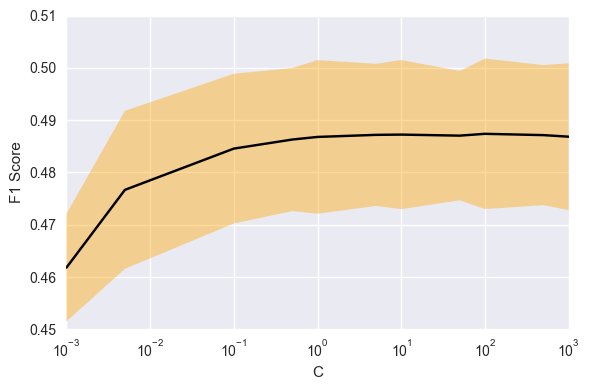

In [181]:
fig = plt.figure(figsize=(6, 4), dpi=100);

axes1 = fig.add_subplot(111);

x  = [param['C'] for param in grid.cv_results_['params']]
y  = grid.cv_results_['mean_test_score']
dy = grid.cv_results_['std_test_score']

axes1.plot(x, y, color='black', ls='-');

axes1.fill_between(x, y-dy, y+dy, where=y+dy>=y-dy, facecolor='orange', interpolate=True, alpha=0.4)

axes1.set_xlim(min(x), max(x))
axes1.set_ylim(0.45, 0.51)
axes1.set_xscale('log')
axes1.set_xlabel('C')
axes1.set_ylabel('F1 Score')
#axes1.grid(False)
#axes1.set_facecolor('white');

fig.tight_layout();

# With TF-IDF Vectorization

Now let's include more complex TF-IDF Bag of Words type features to see how much that improves performance.

In [ ]:
# run the CountVectorizer on the event descriptions and event titles
'''
count_vect_desc  = CountVectorizer(stop_words='english', min_df=25,  ngram_range=(1, 3), analyzer='word')
count_vect_title = CountVectorizer(stop_words='english', min_df=25,  ngram_range=(1, 3), analyzer='word')
count_vect_camp  = CountVectorizer(stop_words='english', min_df=100, ngram_range=(3, 5), analyzer='char')
count_vect_loca  = CountVectorizer(stop_words='english', min_df=50,  ngram_range=(3, 5), analyzer='char')

X        = count_vect_desc.fit_transform(events['Description'].values);
X_titles = count_vect_title.fit_transform(events['Title'].values);
X_camp   = count_vect_camp.fit_transform([str(event) for event in events['Hosted by Camp'].fillna('').values]);
X_loca   = count_vect_camp.fit_transform([str(event) for event in events['Location'].fillna('').values]);

iX_desc  = X.shape[1]
iX_title = X_titles.shape[1]
iX_camp  = X_camp.shape[1]
iX_loca  = X_loca.shape[1]

print(X.shape)
print(X_titles.shape)
print(X_camp.shape)
print(X_loca.shape)

In [412]:
count_vect_desc  = CountVectorizer(stop_words='english', min_df=40,  ngram_range=(1, 3), analyzer='word')

X = count_vect_desc.fit_transform(events['Description'].values);

iX_desc  = X.shape[1]

print(X.shape)

(20165, 3097)


In [414]:
basic_features = ['Contact Email', 'URL', 'Located at Art', 'Event Length', 'Start Time', 'Times Repeated']

print(shape(X));
#print(shape(X_titles));
#print(shape(X_camp));
print(shape(events[days].values));
print(shape(events[basic_features].values));

desc_length = shape(X)[1]

#print(desc_length)

(20165, 3097)
(20165, 9)
(20165, 6)


In [ ]:
'''
enc = OneHotEncoder()
le  = LabelEncoder()

camps = events['Hosted by Camp'].fillna('')

events['Hosted by Camp'] = le.fit_transform(camps)

camps = enc.fit_transform(events[['Hosted by Camp']])

camps.toarray().shape

In [415]:
#X = sparse.csr_matrix(hstack((X.toarray(), X_titles.toarray(), X_camp.toarray(), X_handFeatures, 
#                              events[days].values, events[basic_features].values)))

#X = sparse.csr_matrix(hstack((X.toarray(), X_titles.toarray(), X_handFeatures, camps.toarray(), 
#                              events[days].values, events[basic_features].values)))

X = sparse.csr_matrix(hstack((X.toarray(), X_handFeatures, events[days].values, events[basic_features].values)))

print(shape(X))

(20165, 3139)


In [416]:
all_feature_names = ['str('+name+')' for name in count_vect_desc.get_feature_names()] + features + days + basic_features

In [417]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10082, 3139)
(10083, 3139)
(10082,)
(10083,)


In [418]:
clf = LogisticRegression().fit(X_train, y_train)

pred = clf.predict(X_test)

From the confusion matrix we can see what the most common types of mislabels are. On the top are the predicted labels. On the left are the true labels.

In [419]:
cf = confusion_matrix(y_test, pred)

df_cf = pd.DataFrame(cf, columns=labels, index=labels)

df_cf

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,314,10,91,0,9,23,85,1,14,1,4,10
Care/Support,9,170,83,0,9,8,52,1,28,0,0,12
Class/Workshop,61,39,2773,4,16,16,167,8,40,0,34,52
Fire,1,0,8,40,0,2,14,0,0,0,10,6
Food,4,8,25,0,235,5,124,1,12,0,3,2
Game,10,2,57,0,7,269,92,5,20,0,7,5
Gathering/Party,50,15,189,6,46,42,2124,5,45,13,76,30
Kid-friendly,1,11,45,0,5,13,36,34,23,1,6,6
Other,23,36,190,1,14,30,226,11,106,5,47,22
Parade,1,0,8,0,2,3,31,0,7,76,4,8


Lets normalize it by the total number of samples in each column to make it easier to read.

Predicted adult-oriented events are workshops or parties 23% of the time. Likewise care/support predictions are often classes and 'other' events. Food events are parties 19% of the time. These aren't necessarily mutually exclusive groups, so it may be difficult to reduce this particular type of error.

In [420]:
df_cf_norm = df_cf.copy()

for column in df_cf_norm.columns.values:
    df_cf_norm[column] = round(df_cf_norm[column]/df_cf_norm[column].values.sum(), 2)
    
df_cf_norm

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,0.64,0.03,0.02,0.00,0.03,0.05,0.03,0.01,0.04,0.01,0.01,0.03
Care/Support,0.02,0.55,0.02,0.00,0.03,0.02,0.02,0.01,0.08,0.00,0.00,0.03
Class/Workshop,0.12,0.13,0.76,0.07,0.05,0.04,0.05,0.11,0.12,0.00,0.06,0.14
Fire,0.00,0.00,0.00,0.69,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02
Food,0.01,0.03,0.01,0.00,0.66,0.01,0.04,0.01,0.03,0.00,0.00,0.01
Game,0.02,0.01,0.02,0.00,0.02,0.61,0.03,0.07,0.06,0.00,0.01,0.01
Gathering/Party,0.10,0.05,0.05,0.10,0.13,0.10,0.65,0.07,0.13,0.13,0.12,0.08
Kid-friendly,0.00,0.04,0.01,0.00,0.01,0.03,0.01,0.47,0.07,0.01,0.01,0.02
Other,0.05,0.12,0.05,0.02,0.04,0.07,0.07,0.15,0.31,0.05,0.08,0.06
Parade,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.02,0.76,0.01,0.02


Let's take a look at the classification report to see what the F1 scores by class look like. Identification of workshops is great, but Kid-friendly and other events not so much.

In [421]:
print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
                 precision    recall  f1-score   support

 Adult-oriented       0.64      0.56      0.60       562
   Care/Support       0.55      0.46      0.50       372
 Class/Workshop       0.76      0.86      0.81      3210
           Fire       0.69      0.49      0.58        81
           Food       0.66      0.56      0.61       419
           Game       0.61      0.57      0.59       474
Gathering/Party       0.65      0.80      0.72      2641
   Kid-friendly       0.47      0.19      0.27       181
          Other       0.31      0.15      0.20       711
         Parade       0.76      0.54      0.63       140
    Performance       0.67      0.53      0.59       779
Ritual/Ceremony       0.56      0.42      0.48       513

    avg / total       0.65      0.67      0.65     10083





Let's get a more reliable measurement of the F1 score using 5-fold cross-validation.

In [422]:
scores = cross_val_score(LogisticRegression(), X, y, cv=5, scoring='f1_micro', n_jobs=5)

print('Average F1 Score by CV = ' + str(np.mean(scores)))

Average F1 Score by CV = 0.6549159549648896


Let's run a GridSearch over LogisticRegression's regularization parameter to see what looks best. The black curve is the measured F1 score and the orange region corresponds to the standard deviation. A regularization parameter C of 0.1 is probably best.

In [109]:
params = {'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}

grid = GridSearchCV(LogisticRegression(), param_grid=params, scoring='f1_micro', n_jobs=6, verbose=1, cv=10)

grid.fit(X, y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 110 out of 110 | elapsed: 23.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

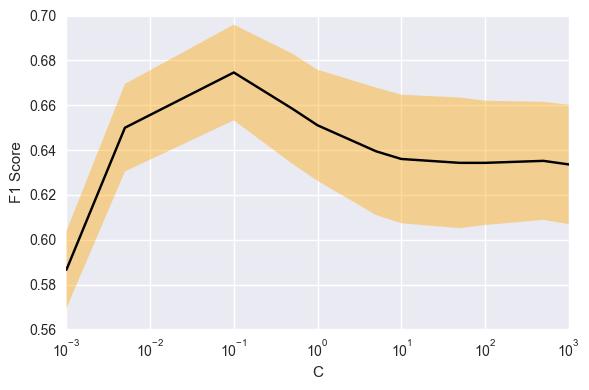

In [168]:
fig = plt.figure(figsize=(6, 4), dpi=100);

axes1 = fig.add_subplot(111);

x  = [param['C'] for param in grid.cv_results_['params']]
y  = grid.cv_results_['mean_test_score']
dy = grid.cv_results_['std_test_score']

axes1.plot(x, y, color='black', ls='-');

axes1.fill_between(x, y-dy, y+dy, where=y+dy>=y-dy, facecolor='orange', interpolate=True, alpha=0.4)

axes1.set_xlim(min(x), max(x))
axes1.set_ylim(0.56, 0.7)
axes1.set_xscale('log')
axes1.set_xlabel('C')
axes1.set_ylabel('F1 Score')
#axes1.grid(False)
#axes1.set_facecolor('white');

fig.tight_layout();

# LightGBM

In [423]:
clf = lgb.LGBMClassifier().fit(X_train.toarray(), y_train, feature_name=all_feature_names)

pred = clf.predict(X_test.toarray())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [424]:
cf = confusion_matrix(y_test, pred)

df_cf = pd.DataFrame(cf, columns=labels, index=labels)

df_cf

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,201,11,165,1,12,19,127,0,14,2,8,2
Care/Support,11,92,127,0,13,4,73,2,38,0,2,10
Class/Workshop,26,25,2780,0,11,12,247,8,39,5,24,33
Fire,1,0,9,22,0,1,26,0,1,0,16,5
Food,2,5,79,2,141,5,169,2,6,0,4,4
Game,9,7,110,1,2,181,116,3,24,4,12,5
Gathering/Party,19,11,340,7,55,36,2030,5,35,7,70,26
Kid-friendly,7,6,54,0,3,6,44,21,35,1,4,0
Other,16,32,225,1,12,28,225,12,101,2,42,15
Parade,0,0,16,0,1,3,65,1,5,43,1,5


In [425]:
df_cf_norm = df_cf.copy()

for column in df_cf_norm.columns.values:
    df_cf_norm[column] = round(df_cf_norm[column]/df_cf_norm[column].values.sum(), 2)
    
df_cf_norm

,Adult-oriented,Care/Support,Class/Workshop,Fire,Food,Game,Gathering/Party,Kid-friendly,Other,Parade,Performance,Ritual/Ceremony
Adult-oriented,0.66,0.05,0.04,0.03,0.04,0.06,0.04,0.00,0.04,0.03,0.02,0.01
Care/Support,0.04,0.44,0.03,0.00,0.05,0.01,0.02,0.03,0.11,0.00,0.00,0.04
Class/Workshop,0.09,0.12,0.65,0.00,0.04,0.04,0.07,0.14,0.11,0.07,0.05,0.14
Fire,0.00,0.00,0.00,0.56,0.00,0.00,0.01,0.00,0.00,0.00,0.03,0.02
Food,0.01,0.02,0.02,0.05,0.52,0.02,0.05,0.03,0.02,0.00,0.01,0.02
Game,0.03,0.03,0.03,0.03,0.01,0.58,0.03,0.05,0.07,0.06,0.02,0.02
Gathering/Party,0.06,0.05,0.08,0.18,0.20,0.12,0.59,0.09,0.10,0.10,0.13,0.11
Kid-friendly,0.02,0.03,0.01,0.00,0.01,0.02,0.01,0.36,0.10,0.01,0.01,0.00
Other,0.05,0.15,0.05,0.03,0.04,0.09,0.07,0.21,0.30,0.03,0.08,0.06
Parade,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.02,0.01,0.61,0.00,0.02


In [426]:
print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
                 precision    recall  f1-score   support

 Adult-oriented       0.66      0.36      0.46       562
   Care/Support       0.44      0.25      0.32       372
 Class/Workshop       0.65      0.87      0.74      3210
           Fire       0.56      0.27      0.37        81
           Food       0.52      0.34      0.41       419
           Game       0.58      0.38      0.46       474
Gathering/Party       0.59      0.77      0.67      2641
   Kid-friendly       0.36      0.12      0.18       181
          Other       0.30      0.14      0.19       711
         Parade       0.61      0.31      0.41       140
    Performance       0.61      0.41      0.49       779
Ritual/Ceremony       0.52      0.24      0.33       513

    avg / total       0.58      0.60      0.57     10083





In [428]:
params = {'learning_rate': [1e-2, 1e-1, 1e0, 1e1, 1e2],
          'num_leaves':    [2, 4, 8, 16, 32, 64, 128],
          'n_estimators':  [8, 16, 32, 64, 128, 256],
          'reg_lambda':    [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
          'reg_alpha':    [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
          'subsample':     [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'max_depth':     [-1, 1, 2, 3, 4, 5]}

n_iter = 100

grid = RandomizedSearchCV(lgb.LGBMClassifier(), param_distributions=params, n_iter=n_iter, scoring='f1_micro', n_jobs=5, verbose=2, cv=5)

grid.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   33.9s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  7.7min
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:  9.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
          fit_params=None, iid=True, n_iter=100, n_jobs=5,
          param_distributions={'learning_rate': [0.01, 0.1, 1.0, 10.0, 100.0], 'num_leaves': [2, 4, 8, 16, 32, 64, 128], 'n_estimators': [8, 16, 32, 64, 128, 256], 'reg_lambda': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'reg_alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [-1, 1, 2, 3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_micro', verbose=2)

In [429]:
grid.best_score_

0.6602033225886437

In [430]:
grid.best_params_

{'learning_rate': 1.0,
 'max_depth': 2,
 'n_estimators': 256,
 'num_leaves': 32,
 'reg_alpha': 0.1,
 'reg_lambda': 10.0,
 'subsample': 1.0}

In [431]:
clf = lgb.LGBMClassifier(learning_rate=grid.best_params_['learning_rate'],
                         n_estimators=grid.best_params_['n_estimators'],
                         num_leaves=grid.best_params_['num_leaves'],
                         reg_lambda=grid.best_params_['reg_lambda'],
                         reg_alpha=grid.best_params_['reg_alpha'],
                         subsample=grid.best_params_['subsample'],
                        ).fit(X_train.toarray(), y_train, feature_name=all_feature_names)

pred = clf.predict(X_test.toarray())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [432]:
print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
                 precision    recall  f1-score   support

 Adult-oriented       0.59      0.48      0.53       562
   Care/Support       0.48      0.31      0.38       372
 Class/Workshop       0.73      0.86      0.79      3210
           Fire       0.55      0.41      0.47        81
           Food       0.57      0.44      0.50       419
           Game       0.57      0.47      0.52       474
Gathering/Party       0.64      0.77      0.70      2641
   Kid-friendly       0.47      0.23      0.31       181
          Other       0.29      0.20      0.24       711
         Parade       0.66      0.39      0.49       140
    Performance       0.60      0.50      0.54       779
Ritual/Ceremony       0.47      0.32      0.38       513

    avg / total       0.61      0.64      0.62     10083





Redefining LGB's plot_importance() function to round the labels. Otherwise the endless decimals just dominate.

In [433]:
from lightgbm import LGBMModel

def plot_importance(booster, ax=None, height=0.2,
                    xlim=None, ylim=None, title='Feature importance',
                    xlabel='Feature importance', ylabel='Features',
                    importance_type='split', max_num_features=None,
                    ignore_zero=True, figsize=None, grid=True, **kwargs):

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError('You must install matplotlib to plot importance.')

    if isinstance(booster, LGBMModel):
        booster = booster.booster_
    elif not isinstance(booster, Booster):
        raise TypeError('booster must be Booster or LGBMModel.')

    importance = booster.feature_importance(importance_type=importance_type)
    feature_name = booster.feature_name()

    if not len(importance):
        raise ValueError('Booster feature_importances are empty.')

    tuples = sorted(zip(feature_name, importance), key=lambda x: x[1])
    if ignore_zero:
        tuples = [x for x in tuples if x[1] > 0]
    if max_num_features is not None and max_num_features > 0:
        tuples = tuples[-max_num_features:]
    labels, values = zip(*tuples)

    if ax is None:
        if figsize is not None:
            check_not_tuple_of_2_elements(figsize, 'figsize')
        _, ax = plt.subplots(1, 1, figsize=figsize)

    ylocs = np.arange(len(values))
    ax.barh(ylocs, values, align='center', height=height, **kwargs)

    for x, y in zip(values, ylocs):
        ax.text(x + 1, y, int(x), va='center', alpha=0.4, fontsize=9)

    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)

    if xlim is not None:
        check_not_tuple_of_2_elements(xlim, 'xlim')
    else:
        xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)

    if ylim is not None:
        check_not_tuple_of_2_elements(ylim, 'ylim')
    else:
        ylim = (-1, len(values))
    ax.set_ylim(ylim)

    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.grid(grid)
    return ax

By both metrics, the Event Length is the most important variables by a substantial margine. The hand crafted features also tend to be the most important. Words like party, stage, game, learn, yoga, parade, tournament, 18, and camp also tend to be really important.

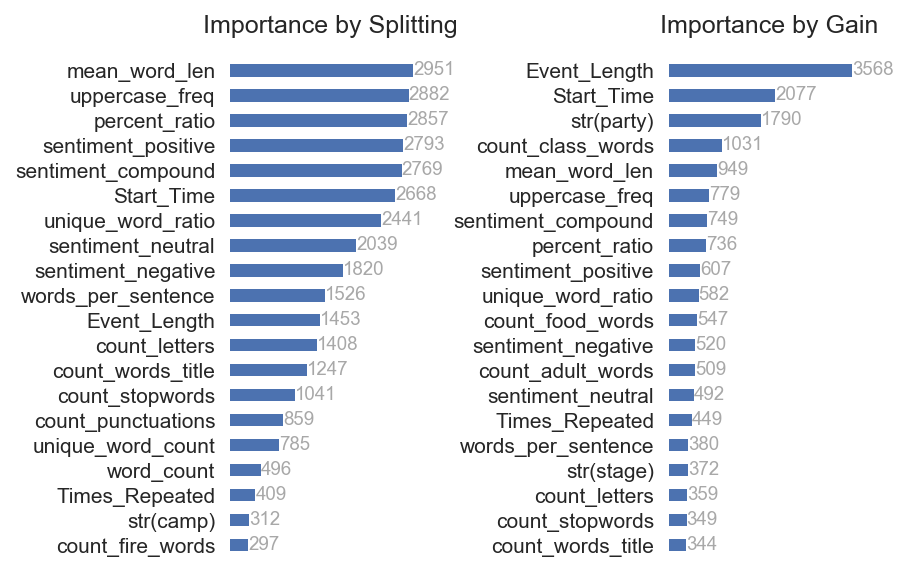

In [435]:
fig = plt.figure(figsize=(6, 4), dpi=150)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_importance(clf, height=0.5, ax=ax1, importance_type='split', xlabel='Feature Importance', ylabel=None, max_num_features=20)
plot_importance(clf, height=0.5, ax=ax2, importance_type='gain',  xlabel='Feature Importance', ylabel=None, max_num_features=20)

ax1.grid(False);ax2.grid(False);
ax1.set_title('Importance by Splitting');ax2.set_title('Importance by Gain');

ax1.set_facecolor('white');ax2.set_facecolor('white');
#ax1.set_xlim(0, 200)
#ax2.set_xlim(0, 12000)
ax1.set_xticklabels([]);ax2.set_xticklabels([]);
ax1.set_xlabel('');ax2.set_xlabel('');

fig.tight_layout()